In [34]:
# Imports here
import torch
import PIL
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchvision import datasets, transforms, models
from torch import nn
from torch import optim
from collections import OrderedDict
from time import time
import copy
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
import skimage.io as io
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [35]:
data_dir = '/kaggle/input/satellite-image-classification'
train_dir = data_dir + '/data'

# Define your transformations
train_transforms = transforms.Compose([
    #transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load all the images from the train folder
all_data = datasets.ImageFolder(train_dir, transform=train_transforms)

# Calculate the sizes for train, validation, and test sets
total_size = len(all_data)
train_size = int(0.7 * total_size)
test_size = int(0.2 * total_size)
valid_size = total_size - train_size - test_size

# Use random_split to split the dataset
train_data, valid_data, test_data = torch.utils.data.random_split(all_data, [train_size, valid_size, test_size])

# Create data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=False)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=50)
testloader = torch.utils.data.DataLoader(test_data, batch_size=50)

In [ ]:
# Load a pre-trained network 
model = models.vgg16(pretrained=True)
model.name = "vgg16"
model

In [89]:
for param in model.parameters():
    param.requires_grad = False

In [90]:
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096, bias=True)),
                          ('relu1', nn.ReLU()),
                          ('dropout1', nn.Dropout(p=0.5)),
                          ('fc2', nn.Linear(4096, 512, bias=True)),
                          ('relu2', nn.ReLU()),
                          ('dropout2', nn.Dropout(p=0.5)),
                          ('fc3', nn.Linear(512, 256, bias=True)),
                          ('relu3', nn.ReLU()),
                          ('dropout3', nn.Dropout(p=0.5)),
                          ('fc4',nn.Linear(256,4,bias=True)),
                          ('output', nn.Softmax(dim=1))
                          ]))
    
model.classifier = classifier

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
model.to(device)

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

epochs = 5
print_every = 30 # Prints every 30 images out of batch of 50 images
steps = 0

In [44]:
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    
    for ii, (inputs, labels) in enumerate(testloader):
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        output = model.forward(inputs)
        test_loss += criterion(output, labels).item()
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [45]:
def train(model,steps,print_every,epochs):
    print("Training process initializing .....\n")

    for e in range(epochs):
        running_loss = 0
        model.train() 
    
        for ii, (inputs, labels) in enumerate(trainloader):
            steps += 1
        
            inputs, labels = inputs.to(device), labels.to(device)
        
            optimizer.zero_grad()
        
            # Forward and backward passes
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
        
            if steps % print_every == 0:
                model.eval()

                with torch.no_grad():
                    valid_loss, accuracy = validation(model, validloader, criterion)
            
                print("Epoch: {}/{} | ".format(e+1, epochs),
                      "Training Loss: {:.4f} | ".format(running_loss/print_every),
                      "Validation Loss: {:.4f} | ".format(valid_loss/len(validloader)),
                      "Validation Accuracy: {:.4f}".format(accuracy/len(validloader)))
            
                running_loss = 0
                model.train()

    print("\nTraining process is now complete!!")
    return model

In [46]:
model = train(model,steps,print_every,epochs)

Training process initializing .....

Epoch: 1/5 |  Training Loss: 0.9172 |  Validation Loss: 0.8326 |  Validation Accuracy: 0.9069
Epoch: 1/5 |  Training Loss: 0.7788 |  Validation Loss: 0.7917 |  Validation Accuracy: 0.9524
Epoch: 2/5 |  Training Loss: 0.2879 |  Validation Loss: 0.7727 |  Validation Accuracy: 0.9690
Epoch: 2/5 |  Training Loss: 0.7663 |  Validation Loss: 0.7493 |  Validation Accuracy: 0.9950
Epoch: 2/5 |  Training Loss: 0.7765 |  Validation Loss: 0.7861 |  Validation Accuracy: 0.9555
Epoch: 3/5 |  Training Loss: 0.5718 |  Validation Loss: 0.7743 |  Validation Accuracy: 0.9681
Epoch: 3/5 |  Training Loss: 0.7766 |  Validation Loss: 0.7925 |  Validation Accuracy: 0.9505
Epoch: 4/5 |  Training Loss: 0.0757 |  Validation Loss: 0.7657 |  Validation Accuracy: 0.9783
Epoch: 4/5 |  Training Loss: 0.7663 |  Validation Loss: 0.7629 |  Validation Accuracy: 0.9807
Epoch: 4/5 |  Training Loss: 0.7779 |  Validation Loss: 0.7685 |  Validation Accuracy: 0.9750
Epoch: 5/5 |  Training 

In [47]:
def pred(Model,Testloader):
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0
    start_time = time()
    with torch.no_grad():
        Model.eval()
        for images, labels in Testloader:
            all_labels.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = Model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_tensor_cpu = predicted.to('cpu')
            all_predictions.extend(predicted_tensor_cpu.numpy())
    end_time = time()
    print("Time: ",end_time - start_time)
    print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
    
    return all_labels,all_predictions

In [50]:
labels_fp32,predictions_fp32 = pred(model,testloader)

Time:  9.768680572509766
Accuracy achieved by the network on test images is: 98%


In [51]:
import seaborn as sns
def metrics(labels,predictions):
    classes = train_data.dataset.classes
    cm = confusion_matrix(np.array(labels), np.array(predictions))
    print("Confusion Matrix:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    print('----------------------------------------------------------------')
    print("Classification Report:")
    report = classification_report(np.array(labels),np.array(predictions))
    print(report)

Confusion Matrix:


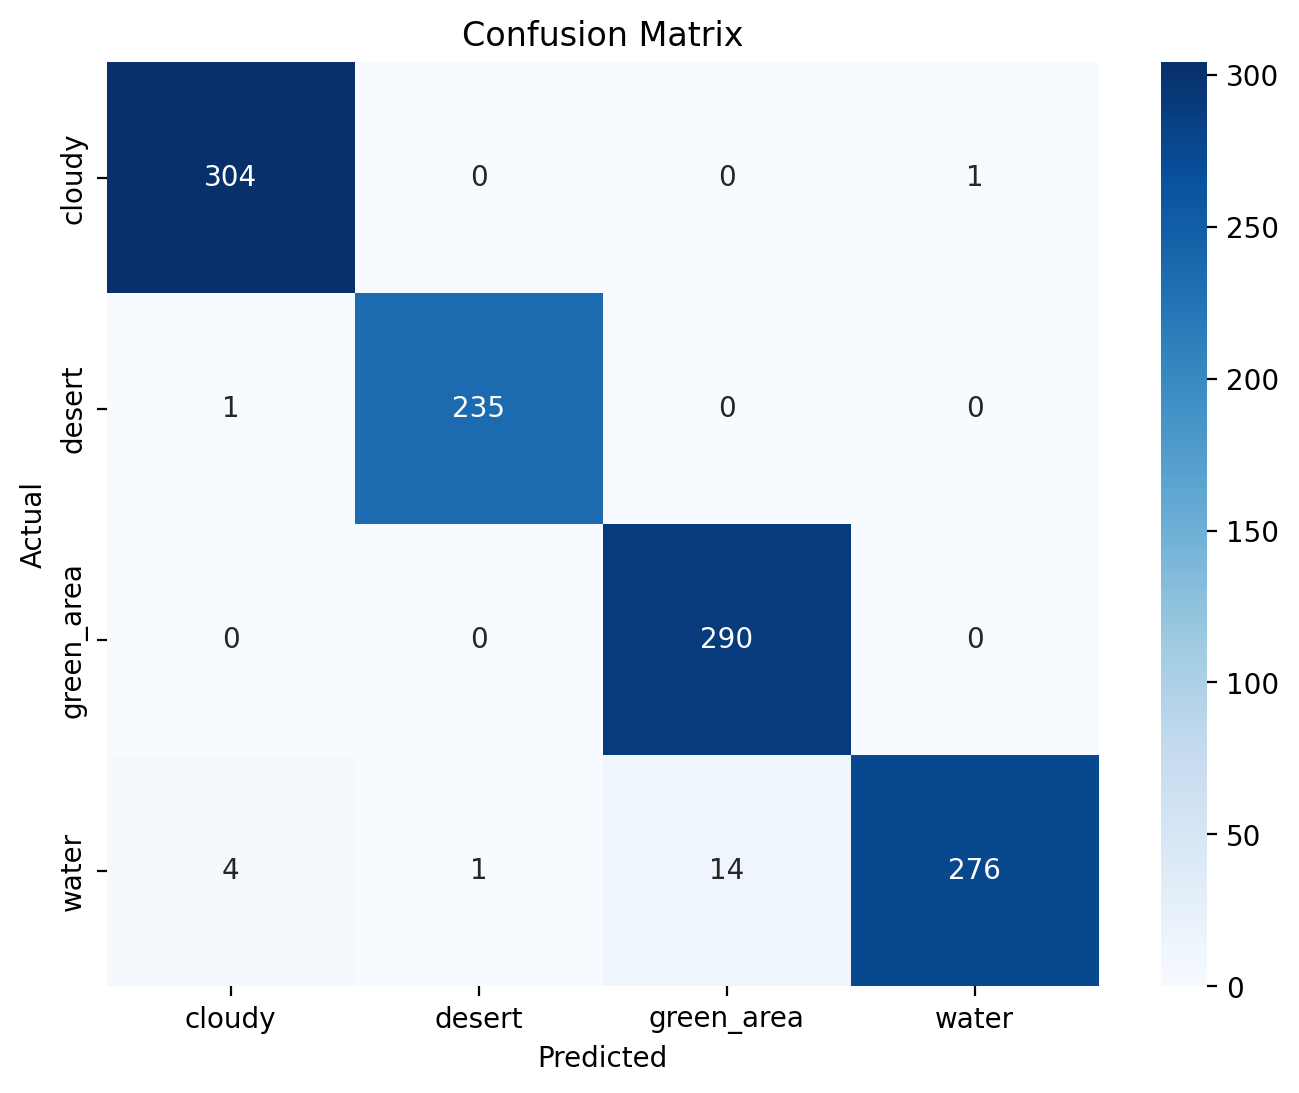

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       305
           1       1.00      1.00      1.00       236
           2       0.95      1.00      0.98       290
           3       1.00      0.94      0.97       295

    accuracy                           0.98      1126
   macro avg       0.98      0.98      0.98      1126
weighted avg       0.98      0.98      0.98      1126



In [52]:
metrics(labels_fp32,predictions_fp32)

In [ ]:
import os
def print_model_size(mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    print("%.2f MB" %(os.path.getsize("tmp.pt")/1e6))
    os.remove('tmp.pt')

In [ ]:
print("Size of fp32 model:",end='')
print_model_size(model)

# Quantization

# FP-16

In [53]:
model_fp16 = copy.deepcopy(model)

In [ ]:
model_fp16.half()
model_fp16.to(device)

In [57]:
def pred_fp16(Model,Testloader):
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0
    start_time = time()
    with torch.no_grad():
        Model.eval()
        for images, labels in Testloader:
            all_labels.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = Model(images.half())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_tensor_cpu = predicted.to('cpu')
            all_predictions.extend(predicted_tensor_cpu.numpy())
    end_time = time()
    print("Time: ",end_time - start_time)
    print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
    
    return all_labels,all_predictions

In [58]:
labels_fp16,predictions_fp16 = pred_fp16(model_fp16,testloader)

Time:  5.812454700469971
Accuracy achieved by the network on test images is: 98%


Confusion Matrix:


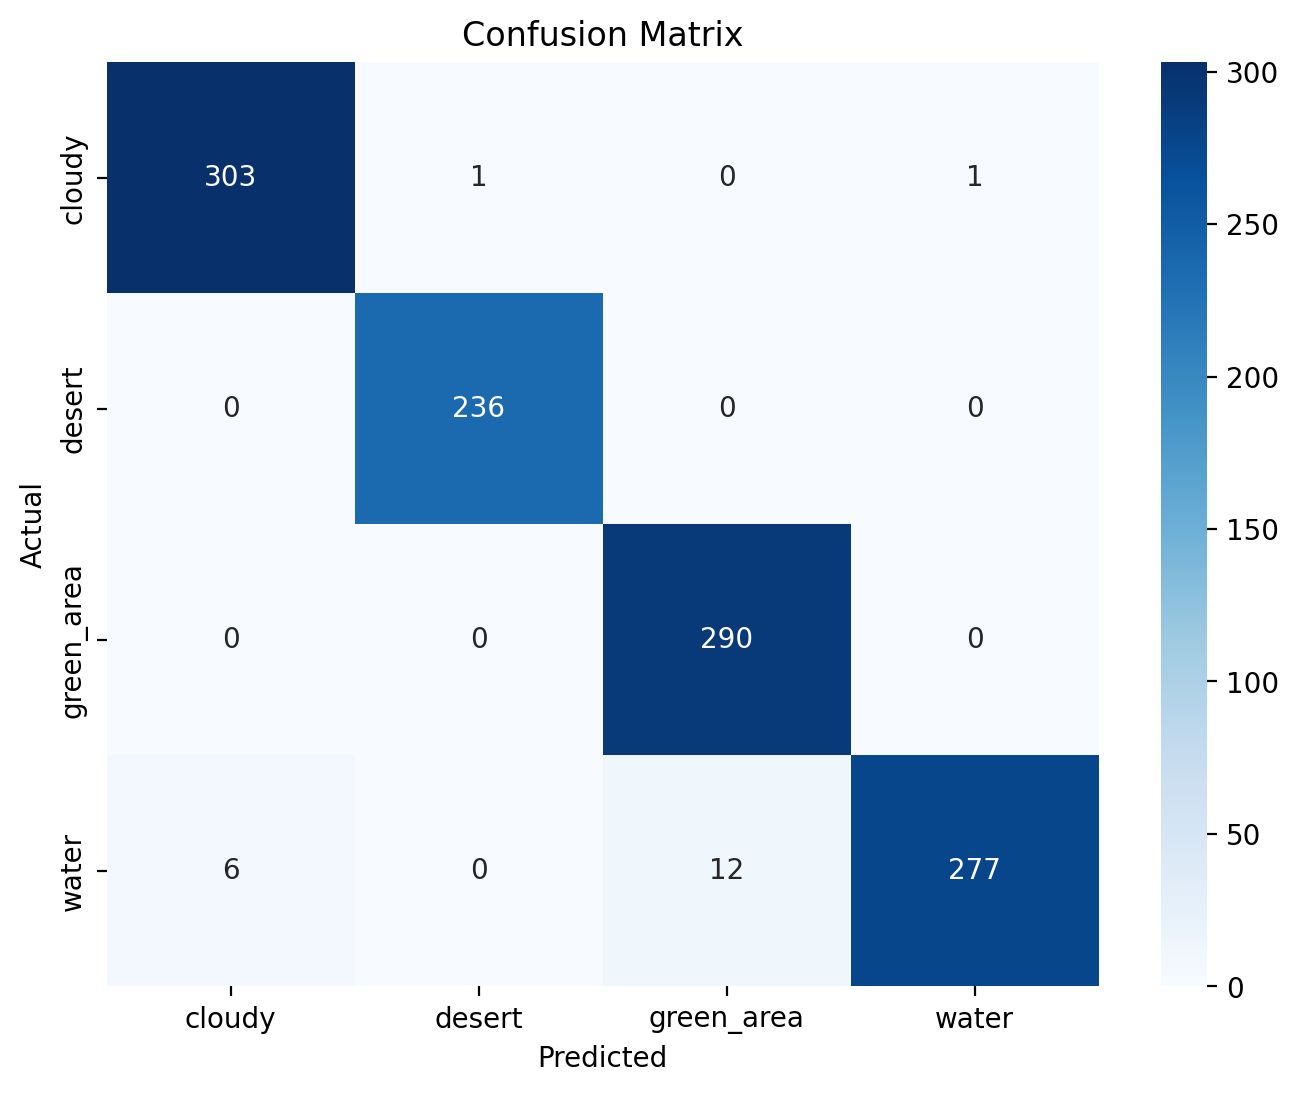

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       305
           1       1.00      1.00      1.00       236
           2       0.96      1.00      0.98       290
           3       1.00      0.94      0.97       295

    accuracy                           0.98      1126
   macro avg       0.98      0.98      0.98      1126
weighted avg       0.98      0.98      0.98      1126



In [59]:
metrics(labels_fp16,predictions_fp16)

## INT-8

In [61]:
import torch
from torch.ao.quantization import (
  get_default_qconfig_mapping,
  get_default_qat_qconfig_mapping,
  QConfigMapping,
)
import torch.ao.quantization.quantize_fx as quantize_fx

### PTQ

In [ ]:
model.to('cpu')

In [63]:
input_data = next(iter(trainloader))[0] 
calibrate_data = input_data.to("cpu")

In [ ]:
model_int8 = copy.deepcopy(model)

qconfig_mapping = get_default_qconfig_mapping("x86")
model_int8.eval()
# prepare
model_prepared = quantize_fx.prepare_fx(model_int8, qconfig_mapping, calibrate_data)
# calibrate

In [66]:
with torch.no_grad():
    for i in range(20):
        batch = next(iter(trainloader))[0]
        output = model_prepared(batch.to('cpu'))

In [ ]:
model_quantized_static = quantize_fx.convert_fx(model_prepared)
model_quantized_static.state_dict()

In [ ]:
model_quantized_static

In [69]:
model_quantized_static.to('cpu')

GraphModule(
  (features): Module(
    (0): QuantizedConvReLU2d(3, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.042026493698358536, zero_point=0, padding=(1, 1))
    (2): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.07731416821479797, zero_point=0, padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): QuantizedConvReLU2d(64, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.07655554264783859, zero_point=0, padding=(1, 1))
    (7): QuantizedConvReLU2d(128, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.0958261787891388, zero_point=0, padding=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): QuantizedConvReLU2d(128, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.13942766189575195, zero_point=0, padding=(1, 1))
    (12): QuantizedConvReLU2d(256, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.14330141246318817, zero_point=0, padding=(1, 1))
    (14): Quant

In [70]:
all_predictions_int8 = []
all_labels_int8 = []
correct_pred = 0
total_pred = 0
start_time_int8 = time()
with torch.no_grad():
    model_quantized_static.eval()
    for data in testloader:
        images, labels = data
        all_labels_int8.extend(labels.numpy())
        #images, labels = images.to(device), labels.to(device)
        outputs = model_quantized_static(images.to('cpu'))
        _, predicted = torch.max(outputs.data, 1)
        total_pred += labels.size(0)
        correct_pred += (predicted == labels).sum().item()
        predicted_tensor_cpu = predicted.to('cpu')
        all_predictions_int8.extend(predicted_tensor_cpu.numpy())
end_time_int8 = time()
print("Time: ",end_time_int8 - start_time_int8)
print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct_pred / total_pred))

Time:  134.9792160987854
Accuracy achieved by the network on test images is: 98%


Confusion Matrix:


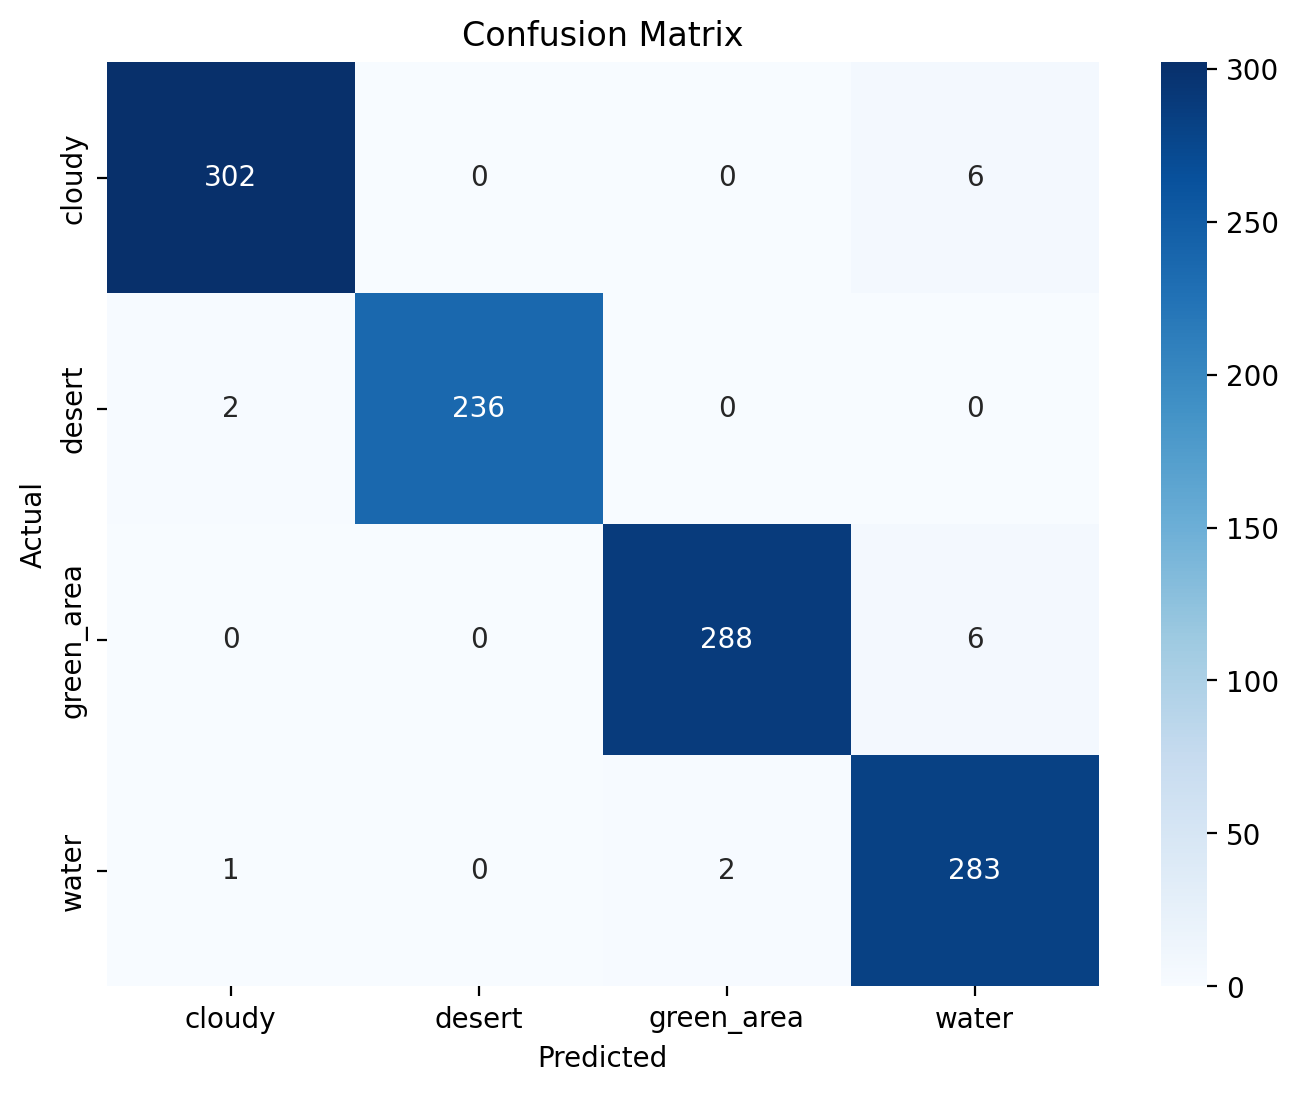

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       308
           1       1.00      0.99      1.00       238
           2       0.99      0.98      0.99       294
           3       0.96      0.99      0.97       286

    accuracy                           0.98      1126
   macro avg       0.99      0.99      0.99      1126
weighted avg       0.99      0.98      0.98      1126



In [71]:
metrics(all_predictions_int8,all_labels_int8)

### QAT

Load a new vgg model which is not trained before starting qat

In [91]:
input_data = next(iter(trainloader))[0]
calibrate_data = input_data.to(device)

In [ ]:
model.eval()
model.qconfig = torch.ao.quantization.get_default_qat_qconfig('x86')
model.train()

In [ ]:
qconfig_mapping = get_default_qat_qconfig_mapping("x86")
model_prepared = quantize_fx.prepare_qat_fx(model, qconfig_mapping, calibrate_data)

In [ ]:
model_prepared.to(device)

In [ ]:
model_prepared = train(model_prepared,steps,print_every,epochs)

In [ ]:
model_prepared.to('cpu')

In [ ]:
model_quantized_trained = quantize_fx.convert_fx(model_prepared)

In [ ]:
model_quantized_trained.to('cpu')

In [ ]:
all_predictions_int8 = []
all_labels_int8 = []
correct_pred = 0
total_pred = 0
start_time_int8 = time()
with torch.no_grad():
    model_quantized_trained.eval()
    for data in testloader:
        images, labels = data
        all_labels_int8.extend(labels.numpy())
        #images, labels = images.to(device), labels.to(device)
        outputs = model_quantized_trained(images.to('cpu'))
        _, predicted = torch.max(outputs.data, 1)
        total_pred += labels.size(0)
        correct_pred += (predicted == labels).sum().item()
        predicted_tensor_cpu = predicted.to('cpu')
        all_predictions_int8.extend(predicted_tensor_cpu.numpy())
end_time_int8 = time()
print("Time: ",end_time_int8 - start_time_int8)
print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct_pred / total_pred))

In [ ]:
metrics(all_predictions_int8,all_labels_int8)

In [ ]:
print("Size of fp16 model:",end='')
print_model_size(model_fp16)
print("Size of PTQ model:",end='')
print_model_size(model_quantized_static)
print("Size of QAT model:",end='')
print_model_size(model_quantized_trained)